## 1. Setting Up the Environment

Before we dive into building our agent, we need to set up the necessary environment. This involves installing required packages and ensuring our Python environment is ready for development.

In [52]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph

Note: you may need to restart the kernel to use updated packages.


In [53]:
# Import necessary libraries
from termcolor import colored
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from datetime import datetime, timezone
import time

## 3: Defining the Agent Graph State

In this step, we define the structure of the state that our agents will use to store and communicate information. This state acts as a shared memory that different components of the system can access and modify. We use the `TypedDict` from the `typing` module to define the expected structure and types of data within the state. This helps ensure consistency and correctness when accessing or updating the state, making it easier to manage complex workflows and data dependencies.

The `AgentGraphState` class includes fields for the research question, responses from the planner agent, and any final outputs or end states. The `get_agent_graph`_state function is used to retrieve specific parts of the state based on a key, facilitating modular and reusable access to the state data.

In [54]:
# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    start_chain: Annotated[list, add_messages]
    transcription_response: Annotated[list, add_messages]
    portuguese_response: Annotated[list, add_messages]
    spanish_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]

# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):

    if state_key == "transcription_all":
        return state["transcription_response"]
    elif state_key == "transcription_latest":
        return state["transcription_response"][-1]if state["transcription_response"] else []

    if state_key == "portuguese_all":
        return state["portuguese_response"]
    elif state_key == "portuguese_latest":
        return state["portuguese_response"][-1] if state["portuguese_response"] else []

    if state_key == "spanish_all":
        return state["spanish_response"]
    elif state_key == "spanish_latest":
        return state["spanish_response"][-1] if state["spanish_response"] else []

    else:
        return None

# Initial state setup
state = {
    "start_chain": [],
    "transcription_response": [],
    "portuguese_response": [],
    "spanish_response": [],
    "end_chain": [],
}

## 4. Agent Class Definition

In this section, we define the `Agent` class, which serves as a base class for different types of agents in our system. An agent is a component that interacts with the language model to perform specific tasks, such as generating responses or processing information. The `Agent` class manages the configuration and state associated with the language model, allowing for easy setup and reuse of model configurations across different agents.

The class includes methods for initializing the agent with a specific model configuration and updating the agent's state. The state encapsulates the context or memory of the agent, enabling it to maintain continuity across interactions.

In [55]:
class Agent:
    def __init__(self, state: AgentGraphState):
        self.state = state

    def update_state(self, key: str, value: any):
        if key in self.state:
            self.state[key] = value
        else:
            print(f"Warning: Attempting to update a non-existing state key '{key}'.")

## 5. Utility Functions

Utility functions are auxiliary functions that assist with various common tasks within the notebook. They help keep the codebase clean and modular by encapsulating frequently used logic in separate functions. In this case, we have two utility functions: `check_for_content` and `get_current_utc_datetime`.

- `check_for_content`: This function checks if a variable has a content attribute and returns its value if it exists. This is useful for handling different data types that may or may not have a content attribute.
- `get_current_utc_datetime`: This function returns the current date and time in UTC format. This can be useful for timestamping events or logging.

In [56]:
# Get the current date and time in UTC
def get_current_utc_datetime():
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S.%f UTC")[:-3]  # Truncate to milliseconds

## 6. TranscriptAgent

In [57]:
import asyncio

class TranscriptAgent(Agent):

    def __init__(self, state: AgentGraphState, file_path: str):
        super().__init__(state)
        self.file_path = file_path
        self.lines = None

    def load_file(self):
        if not self.lines:
            with open(self.file_path) as f:
                self.lines = [line.strip() for line in f]

    async def invoke(self) -> dict:
        print(
            colored(f"TRANSCRIPT_AGENT  📝: INVOKE", "cyan")
        )
        if not self.lines:
            self.load_file()

        current_line_index = 0
        while current_line_index < len(self.lines):
            print(
                colored(
                    f"TRANSCRIPT_AGENT  📝: { self.lines[current_line_index]}", "cyan"
                )
            )
            self.update_state(
                "transcription_response", self.lines[current_line_index]
            )
            await asyncio.sleep(4)  # Simulate async operation
            current_line_index += 1

        if not self.lines:
            self.update_state("transcription_response", "END")
            self.update_state("end_chain", "END")

        print(
            colored(f"TRANSCRIPT_AGENT  📝: RETURN STATE", "cyan")
        )
        return self.state

In [58]:
class TranslanteAgent(Agent):

    def translate(self):
        timestamp = get_current_utc_datetime()
        print(colored(f"TRANSLATE_AGENT 🗣️: {timestamp}", "yellow"))

    def invoke(
        self,
    ) -> dict:
        print(colored(f"TRANSLATE_AGENT 🗣️: {self.state}", "yellow"))
        return self.state

In [59]:
async def should_continue(state: AgentGraphState):
    print(colored(f"Recording has finished", "red"))
    recording = state["end_chain"]

    # Determine the next step based on the verification status
    if recording:
        print(colored(f"Recording has finished", "red"))
        return "end"
    else:
        print(colored(f"Still recording...", "green"))
        time.sleep(5)
        return ["translate_node_1", "translate_node_2"]

In [60]:
from langgraph.graph import START, END, StateGraph


async def text_node_function(state):
    agent = TranscriptAgent(state=state, file_path="text.txt")
    return await agent.invoke()

def create_graph() -> StateGraph:
    graph = StateGraph(AgentGraphState)

    graph.add_node("text_node", text_node_function)

    # graph.add_node(
    #     "text_node",
    #     lambda state: TranscriptAgent(
    #         state=state,
    #     ).invoke(),
    # )

    # graph.add_node(
    #     "translate_node_1",
    #     lambda state: TranslanteAgent(
    #         state=state,
    #     ).invoke(),
    # )

    # graph.add_node(
    #     "translate_node_2",
    #     lambda state: TranslanteAgent(
    #         state=state,
    #     ).invoke(),
    # )

    # Set the entry and finish points for the workflow
    # graph.set_entry_point(START)
    # graph.set_finish_point(END)

    # Define the flow of the graph

    graph.add_edge(START, "text_node")
    # graph.add_edge("text_node", END)
    # graph.add_edge("translate_node_1", "text_node")
    # graph.add_edge("translate_node_2", "text_node")
    graph.add_conditional_edges(
        "text_node",
        should_continue,
        {
            "text_node": "text_node",
            "end": END,
        },
    )

    return graph

def compile_workflow(graph: StateGraph):
    workflow = graph.compile()
    return workflow

In [61]:
# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")

# Define workflow parameters
iterations = 10
verbose = True
dict_inputs = {"start_chain": "start"}
limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
async for event in workflow.astream(dict_inputs, limit):
    if verbose:
        print("\nState Dictionary:", event)
    else:
        print("\n")

Graph and workflow created.
TRANSCRIPT_AGENT  📝: INVOKE
TRANSCRIPT_AGENT  📝: Hello, world!
TRANSCRIPT_AGENT  📝: This is a test file.
TRANSCRIPT_AGENT  📝: Can you understand me?


CancelledError: 

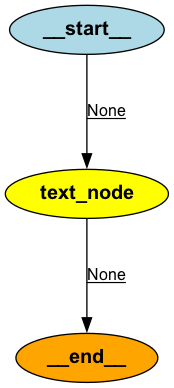

In [ ]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))